# 迁移学习

## 导入需要的包

In [1]:
import tensorflow as tf
import pathlib
import random

导入数据

In [2]:
data_root_orig = r'C:\Users\Administrator\Desktop\transfer learning'
data_root = pathlib.Path(data_root_orig)



all_image_paths = list(data_root.glob('*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [3]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
print(label_names)
label_names.remove('.ipynb_checkpoints')
print(label_names)

['.ipynb_checkpoints', 'daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [4]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [5]:
all_image_labels = [label_to_index.get(pathlib.Path(path).parent.name)
                    for path in all_image_paths]

## 数据集

In [6]:
length = len(all_image_labels)
length

3670

In [7]:
index = tf.range(length)
index = tf.random.shuffle(index)
train_image_paths = tf.gather(all_image_paths, index[:3000])
train_image_labels = tf.gather(all_image_labels, index[:3000])
test_image_paths = tf.gather(all_image_paths, index[3000:])
test_image_labels = tf.gather(all_image_labels, index[3000:])

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
print(train_ds)
print(test_ds)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>


In [9]:
def preprocessing(x, y):
    x = tf.io.read_file(x)# img_raw
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [128, 128])
#     x = (x / 255.0) * 2 - 1  # normalize to [-1,1] range
    x = tf.cast(x, dtype=tf.float32)
    
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 128
train_ds = train_ds.map(preprocessing, num_parallel_calls=AUTOTUNE).batch(batch_size,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocessing, num_parallel_calls=AUTOTUNE).batch(batch_size,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

In [11]:
for images, labels in train_ds.take(1):
    print(images.device)

/job:localhost/replica:0/task:0/device:CPU:0


## 模型

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
img_size = (128,128)
img_shape = img_size + (3,)
img_shape

(128, 128, 3)

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
img_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(img_batch)
print(feature_batch.shape)

(128, 4, 4, 1280)


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 5)


In [20]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(1e-3)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [24]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [25]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 训练

In [26]:
EPOCHS = 50
history_train_loss = []
history_train_accuracy = []
history_test_loss = []
history_test_accuracy = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    history_train_loss.append(train_loss.result().numpy())
    history_train_accuracy.append(train_accuracy.result().numpy())
    history_test_loss.append(test_loss.result().numpy())
    history_test_accuracy.append(test_accuracy.result().numpy())
    print(
          f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}, '
          f'Test Loss: {test_loss.result()}, '
          f'Test Accuracy: {test_accuracy.result() * 100},',
          
        )

Epoch 1, Loss: 1.3382289409637451, Accuracy: 49.388587951660156, Test Loss: 0.7330948710441589, Test Accuracy: 75.46875,
Epoch 2, Loss: 0.6177449226379395, Accuracy: 77.95516204833984, Test Loss: 0.5321513414382935, Test Accuracy: 81.40625,
Epoch 3, Loss: 0.46643170714378357, Accuracy: 83.28804016113281, Test Loss: 0.456333726644516, Test Accuracy: 83.75,
Epoch 4, Loss: 0.39527472853660583, Accuracy: 86.20923614501953, Test Loss: 0.42116332054138184, Test Accuracy: 84.84375,
Epoch 5, Loss: 0.3524816036224365, Accuracy: 87.70380401611328, Test Loss: 0.40043267607688904, Test Accuracy: 84.6875,
Epoch 6, Loss: 0.3211553692817688, Accuracy: 88.8247299194336, Test Loss: 0.3859277367591858, Test Accuracy: 85.15625,
Epoch 7, Loss: 0.30123698711395264, Accuracy: 89.77581024169922, Test Loss: 0.37365084886550903, Test Accuracy: 85.78125,
Epoch 8, Loss: 0.2696966826915741, Accuracy: 90.625, Test Loss: 0.36306729912757874, Test Accuracy: 86.25,
Epoch 9, Loss: 0.2555384337902069, Accuracy: 91.3722

## 画图

In [27]:
import matplotlib.pyplot as plt
def plot_graph(x,y):
    plt.plot(x)
    plt.plot(y)
    plt.show()

In [ ]:
plot_graph(history_train_loss,history_test_loss)

In [ ]:
plot_graph(history_train_accuracy, history_test_accuracy)

In [28]:
base_model.trainable=True

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [30]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

## 微调

In [35]:
EPOCHS = 50
history_train_loss = []
history_train_accuracy = []
history_test_loss = []
history_test_accuracy = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    history_train_loss.append(train_loss.result().numpy())
    history_train_accuracy.append(train_accuracy.result().numpy())
    history_test_loss.append(test_loss.result().numpy())
    history_test_accuracy.append(test_accuracy.result().numpy())
    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 0.08003772050142288, Accuracy: 97.58831024169922, Test Loss: 0.3683057129383087, Test Accuracy: 87.03125
Epoch 2, Loss: 0.069243423640728, Accuracy: 98.33560180664062, Test Loss: 0.3577934801578522, Test Accuracy: 87.5
Epoch 3, Loss: 0.07601619511842728, Accuracy: 97.75814819335938, Test Loss: 0.3567218780517578, Test Accuracy: 86.875
Epoch 4, Loss: 0.06893766671419144, Accuracy: 98.40353393554688, Test Loss: 0.3508451282978058, Test Accuracy: 87.65625
Epoch 5, Loss: 0.06719636172056198, Accuracy: 98.50543975830078, Test Loss: 0.35856685042381287, Test Accuracy: 87.03125
Epoch 6, Loss: 0.06389615684747696, Accuracy: 98.70923614501953, Test Loss: 0.3573974668979645, Test Accuracy: 87.34375
Epoch 7, Loss: 0.06336838006973267, Accuracy: 98.50543975830078, Test Loss: 0.3581295609474182, Test Accuracy: 87.03125
Epoch 8, Loss: 0.06820416450500488, Accuracy: 98.33560180664062, Test Loss: 0.35815662145614624, Test Accuracy: 87.65625
Epoch 9, Loss: 0.06852055341005325, Accuracy: 

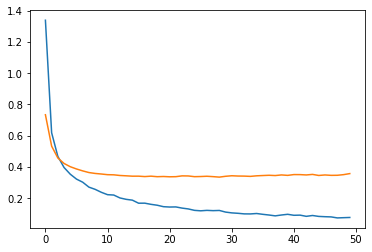

In [33]:
plot_graph(history_train_loss,history_test_loss)

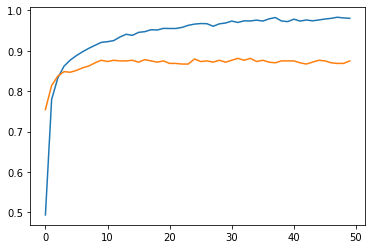

In [34]:
plot_graph(history_train_accuracy, history_test_accuracy)